In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import cv2
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

## 2. Load npz file
The features stored in a *.npz* file and here it will be loaded

In [3]:
f2 = np.load("D:/UM/Project/Mozartify/project/Datasets/Features/Features2D/Features2D.npz")

In [4]:
spec2 = f2['spec'] #(400,1025,1099)
mfcc2 = f2['mfcc'] #(400,20,1099)
mel2 = f2['mel']#(400,128,1099)
y2 = f2['target']

## 3. Data preprocessing
### 3.1 Resize the data

In [5]:
mfcc2_resized = np.empty((mfcc2.shape[0], 120, 600))
for i in range(0,400):
    mfcc2_resized[i] = cv2.resize(mfcc2[i],(600,120))

In [6]:
spec2_resized = np.empty((spec2.shape[0], 300, 300))
for i in range(0,400):
    spec2_resized[i] = cv2.resize(spec2[i],(300,300))

In [7]:
mel2_resized = np.empty((mel2.shape[0], 300, 400))
for i in range(0,400):
    mel2_resized[i] = cv2.resize(mel2[i],(400,300))

### 3.2 Train Test Split

In [8]:
mfcc2_train,mfcc2_test,y2_train,y2_test = train_test_split(mfcc2_resized,y2, 
                                                   train_size = 0.9, 
                                                   random_state = 13, 
                                                   stratify= y2)

In [9]:


np.savez_compressed("D:/UM/Project/Mozartify/project/Datasets/Features/Features2D/training models/mfcc2_train_test.npz",
                    mfcc_train = mfcc2_train, 
                    mfcc_test = mfcc2_test, 
                    y_train = y2_train, 
                    y_test = y2_test)

In [10]:

spec2_train,spec2_test,y2_train,y2_test = train_test_split(spec2_resized,y2, 
                                                           train_size = 0.9, 
                                                           random_state = 13, 
                                                           stratify = y2)

In [11]:


np.savez_compressed("D:/UM/Project/Mozartify/project/Datasets/Features/Features2D/training models/spec2_train_test.npz",
                    spec_train = spec2_train, 
                    spec_test = spec2_test, 
                    y_train = y2_train, 
                    y_test = y2_test)

In [12]:

mel2_train,mel2_test,y2_train,y2_test = train_test_split(mel2_resized,y2, 
                                                           train_size = 0.9,  
                                                           random_state = 13, 
                                                           stratify = y2)

In [13]:


np.savez_compressed("D:/UM/Project/Mozartify/project/Datasets/Features/Features2D/training models/mel2_train_test.npz",
                    mel_train = mel2_train, 
                    mel_test = mel2_test, 
                    y_train = y2_train, 
                    y_test = y2_test)

## 4. Classification

In [14]:
# Train the model
def modelBuilder3L(X_train,
                   f1,k1,a1,
                   mw1,mh1,sw1,sh1,
                   f2,k2,a2,
                   mw2,mh2,sw2,sh2,
                   f3,k3,a3,
                   mw3,mh3,sw3,sh3,
                   d1,dr1,da1,r1,
                   d2,dr2,da2,r2,
                   num):
    
    '''
    args:
    
    X_train: training data
    f1,k1,a1: num of filters, filter size and activation func of 1st conv2D layer
    mr1,mc1,sr1,sc1: filter size and strides of 1st MaxPooling2D layer
    f2,k2,a2: num of filters, filter size and activation func of 2nd conv2D layer
    mr2,mc2,sr2,sc2: filter size and strides of 2nd MaxPooling2D layer
    f3,k3,a3: num of filters, filter size and activation func of 3rd conv2D layer
    mr3,sc3,sr3,sc3: filter size and strides of 3rd MaxPooling2D layer
    d1,dr1,da1, r1: num of units, dropout, activation func and regularizer para of 1st fully connected layer
    d2,dr2,da2, r2: num of units, dropout, activation func and regularizer para of 2nd fully connected layer
    num: integer for distinguishing different model
    
    return:
    model
    
    '''
    
    N,row,col,Nc = X_train.shape
    
    model = Sequential(name = "CNN2D_"+str(num))
    #L1
    model.add(Conv2D(f1,(k1,k1),activation = a1,input_shape = (row,col,Nc), padding = 'same', name = 'Conv2D_1'))
    model.add(MaxPooling2D((mw1,mh1), strides = (sw1,sh1), padding = 'same', name = 'MaxPooling2D_1'))
    model.add(BatchNormalization(name = "BN1"))
    
    #L2
    model.add(Conv2D(f2,(k2,k2), activation = a2, padding = 'same',name = 'Conv2D_2'))
    model.add(MaxPooling2D((mw2,mh2),strides = (sw2,sh2), padding = 'same', name = 'MaxPooling2D_2'))
    model.add(BatchNormalization(name = "BN2"))

    #L3
    model.add(Conv2D(f3,(k3,k3), activation = a3, padding = 'same',name = 'Conv2D_3'))
    model.add(MaxPooling2D((mw3,mh3), strides = (sw3,sh3), padding = 'same', name = 'MaxPooling2D_3'))
    model.add(BatchNormalization(name = "BN3"))
   
    #Flatten layer
    model.add(Flatten(name = 'Flatten'))
    #FC4
    model.add(Dense(d1, activation = da1, kernel_regularizer = tf.keras.regularizers.L2(r1), name='Dense1'))
    model.add(Dropout(dr1, name = "Dropout1"))
    #FC5
    model.add(Dense(d2, activation = da2, kernel_regularizer = tf.keras.regularizers.L2(r2), name='Dense2'))
    model.add(Dropout(dr2, name = "Dropout2"))
    #Softmax layer
    model.add(Dense(4, activation ='softmax', name='Softmax'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer= optimizer, loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    
    return model

### 4.1 MFCC

In [15]:
mfcc2_file = np.load("D:/UM/Project/Mozartify/project/Datasets/Features/Features2D/training models/mfcc2_train_test.npz")
mfcc2_train = mfcc2_file['mfcc_train']
y2_train = mfcc2_file['y_train']

mfcc2_train,mfcc2_val,y2_train,y2_val = train_test_split(mfcc2_train,y2_train, 
                                                         train_size = 0.8,  
                                                         random_state = 13, 
                                                         stratify= y2_train)

In [16]:
# Feature Scaling
mfcc2_train_scaled = (mfcc2_train - np.mean(mfcc2_train))/np.std(mfcc2_train)
mfcc2_val_scaled = (mfcc2_val - np.mean(mfcc2_val))/np.std(mfcc2_val)

In [17]:
# Reshape the data
N,row,col = mfcc2_train_scaled.shape
mfcc2_train_reshaped = mfcc2_train_scaled.reshape((N,row,col,1))
N,row,col = mfcc2_val_scaled.shape
mfcc2_val_reshaped = mfcc2_val_scaled.reshape((N,row,col,1))

In [18]:
f1,k1,a1 = 8,3,'relu'
mw1,mh1,sw1,sh1 = 2,3,2,2
f2,k2,a2 = 8,3,'relu',
mw2,mh2,sw2,sh2 = 2,3,2,2
f3,k3,a3 = 8,3,'relu',
mw3,mh3,sw3,sh3 = 2,3,2,2
d1,dr1,da1,r1 = 64,0.2,'relu',0.2
d2,dr2,da2,r2 = 32,0.2,'relu',0.2
num = 2
model2 = modelBuilder3L(mfcc2_train_reshaped,
                        f1,k1,a1,
                        mw1,mh1,sw1,sh1,
                        f2,k2,a2,
                        mw2,mh2,sw2,sh2,
                        f3,k3,a3,
                        mw3,mh3,sw3,sh3,
                        d1,dr1,da1,r1,
                        d2,dr2,da2,r2,
                        num)

Model: "CNN2D_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)               │ (None, 120, 600, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_1 (MaxPooling2D)   │ (None, 60, 300, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN1 (BatchNormalization)        │ (None, 60, 300, 8)     │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 60, 300, 8)     │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_2 (MaxPooling2D)   │ (None, 30, 150, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN2 (BatchNormalization)        │ (None, 30, 150, 8)     │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 30, 150, 8)     │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_3 (MaxPooling2D)   │ (None, 15, 75, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN3 (BatchNormalization)        │ (None, 15, 75, 8)      │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 9000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 64)             │       576,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Softmax (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,620 (2.21 MB)

 Trainable params: 579,572 (2.21 MB)

 Non-trainable params: 48 (192.00 B)

In [19]:
history2 = model2.fit(mfcc2_train_reshaped,y2_train,validation_data=(mfcc2_val_reshaped,y2_val),batch_size=20,epochs=80)

Epoch 1/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5773 - loss: 33.1535 - val_accuracy: 0.6686 - val_loss: 28.3292
Epoch 2/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6748 - loss: 26.6037 - val_accuracy: 0.4914 - val_loss: 22.8372
Epoch 3/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6782 - loss: 21.4130 - val_accuracy: 0.4971 - val_loss: 18.6056
Epoch 4/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.6545 - loss: 17.5121 - val_accuracy: 0.5771 - val_loss: 15.4068
Epoch 5/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6910 - loss: 14.5577 - val_accuracy: 0.5314 - val_loss: 13.0529
Epoch 6/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6794 - loss: 12.3874 - val_accuracy: 0.5714 - val_loss: 11.2838
Epoch 7/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7043 - loss: 10.6936 - val_accuracy: 0.5886 - val_loss: 9.9584
Epoch 8/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7111 - loss: 9.4610 - val_accurac

Text(0, 0.5, 'loss')

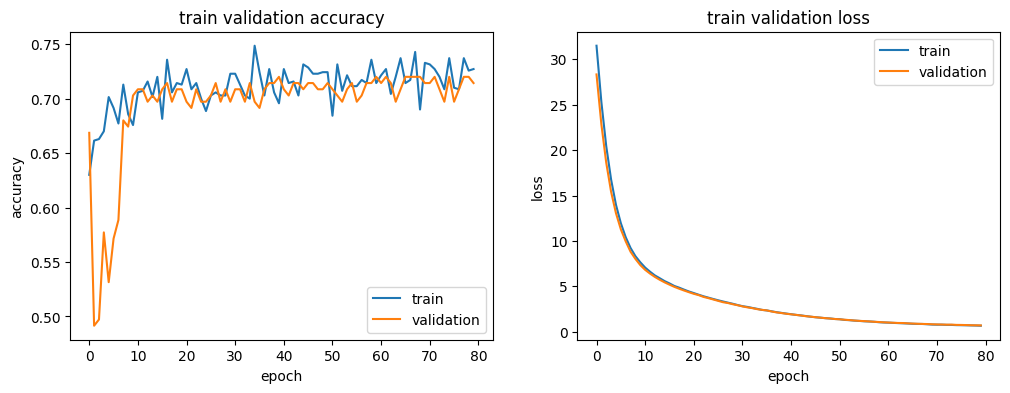

In [20]:
# Train and Validation accuracy and loss
f = plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.title('train validation accuracy')
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(1,2,2)
plt.title('train validation loss')
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

In [21]:
mfcc2_test = mfcc2_file['mfcc_test']
y2_test_mfcc = mfcc2_file['y_test']

In [22]:
# Feature Scaling
mfcc2_test_scaled = (mfcc2_test - np.mean(mfcc2_test))/np.std(mfcc2_test)

# Reshape the data
N,row,col = mfcc2_test_scaled.shape
mfcc2_test_reshaped = mfcc2_test_scaled.reshape((N,row,col,1))

In [23]:
y1_prob = model2.predict(mfcc2_test_reshaped)
y1_pred = np.argmax(y1_prob, axis = -1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [24]:
# Accuracy
acc1_2d = round(accuracy_score(y1_pred,y2_test_mfcc),2)

In [25]:
# Confusion Matrix
cm_mfcc = confusion_matrix(y2_test_mfcc,y1_pred)
cm_2d_mfcc = ConfusionMatrixDisplay(confusion_matrix = cm_mfcc, display_labels = ['Happy', 'Relaxed', 'Sad'])

              precision    recall  f1-score   support

       Happy       0.94      1.00      0.97        32
     Relaxed       1.00      0.27      0.43        33
         Sad       0.60      1.00      0.75        33

    accuracy                           0.76        98
   macro avg       0.85      0.76      0.72        98
weighted avg       0.85      0.76      0.71        98



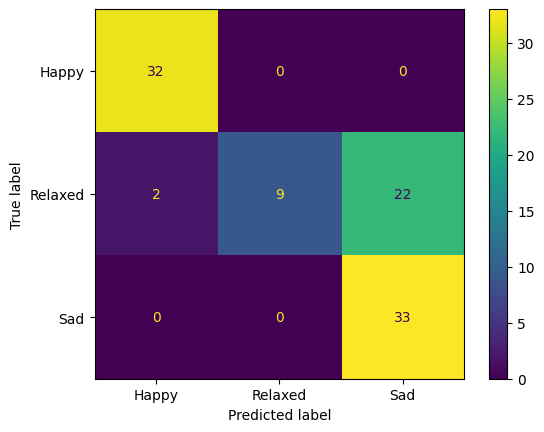

In [26]:
print(classification_report(y2_test_mfcc, y1_pred, target_names = ['Happy', 'Relaxed', 'Sad']))
cm_2d_mfcc.plot()
plt.show()

### 4.2 Spectrogram

In [27]:
# Load Spectrogram data set
spec2_file = np.load("D:/UM/Project/Mozartify/project/Datasets/Features/Features2D/training models/spec2_train_test.npz")

spec2_train = spec2_file['spec_train']
y2_train = spec2_file['y_train']
spec2_train,spec2_val,y2_train,y2_val = train_test_split(spec2_train,y2_train, 
                                                         train_size = 0.8, 
                                                         random_state = 13, 
                                                         stratify = y2_train)

In [28]:
# Feature Scaling
spec2_train_scaled = spec2_train / np.amax(spec2_train)
spec2_val_scaled = spec2_val / np.amax(spec2_val)

In [29]:
# Reshape the data
N,row,col = spec2_train_scaled.shape
spec2_train_reshaped = spec2_train_scaled.reshape((N,row,col,1))
N,row,col = spec2_val_scaled.shape
spec2_val_reshaped = spec2_val_scaled.reshape((N,row,col,1))

In [30]:
f1,k1,a1 = 5,3,'relu'
mw1,mh1,sw1,sh1 = 3,3,2,2
f2,k2,a2 = 8,3,'relu'
mw2,mh2,sw2,sh2 = 3,3,2,2
f3,k3,a3 = 16,3,'relu'
mw3,mh3,sw3,sh3 = 3,3,2,2
d1,dr1,da1,r1 = 64,0.2,'relu',0.2
d2,dr2,da2,r2 = 32,0.2,'relu',0.2
num = 4
model4 = modelBuilder3L(spec2_train_reshaped,
                        f1,k1,a1,
                        mw1,mh1,sw1,sh1,
                        f2,k2,a2,
                        mw2,mh2,sw2,sh2,
                        f3,k3,a3,
                        mw3,mh3,sw3,sh3,
                        d1,dr1,da1,r1,
                        d2,dr2,da2,r2,
                        num)

Model: "CNN2D_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)               │ (None, 300, 300, 5)    │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_1 (MaxPooling2D)   │ (None, 150, 150, 5)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN1 (BatchNormalization)        │ (None, 150, 150, 5)    │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 150, 150, 8)    │           368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_2 (MaxPooling2D)   │ (None, 75, 75, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN2 (BatchNormalization)        │ (None, 75, 75, 8)      │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 75, 75, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_3 (MaxPooling2D)   │ (None, 38, 38, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN3 (BatchNormalization)        │ (None, 38, 38, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 23104)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 64)             │     1,478,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Softmax (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,482,634 (5.66 MB)

 Trainable params: 1,482,576 (5.66 MB)

 Non-trainable params: 58 (232.00 B)

In [31]:
history4 = model4.fit(spec2_train_reshaped,y2_train,validation_data=(spec2_val_reshaped,y2_val),batch_size=20,epochs=80)

Epoch 1/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.5990 - loss: 33.7631 - val_accuracy: 0.3371 - val_loss: 30.0174
Epoch 2/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.6579 - loss: 28.1807 - val_accuracy: 0.3314 - val_loss: 25.0207
Epoch 3/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.6551 - loss: 23.2394 - val_accuracy: 0.3371 - val_loss: 20.7792
Epoch 4/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.6552 - loss: 19.1835 - val_accuracy: 0.4057 - val_loss: 17.4465
Epoch 5/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.6542 - loss: 15.9663 - val_accuracy: 0.3886 - val_loss: 14.9422
Epoch 6/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.6277 - loss: 13.5588 - val_accuracy: 0.3771 - val_loss: 12.8276
Epoch 7/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7083 - loss: 11.5273 - val_accuracy: 0.4057 - val_loss: 11.1116
Epoch 8/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.6787 - loss: 10.0979 - val_accur

Text(0, 0.5, 'loss')

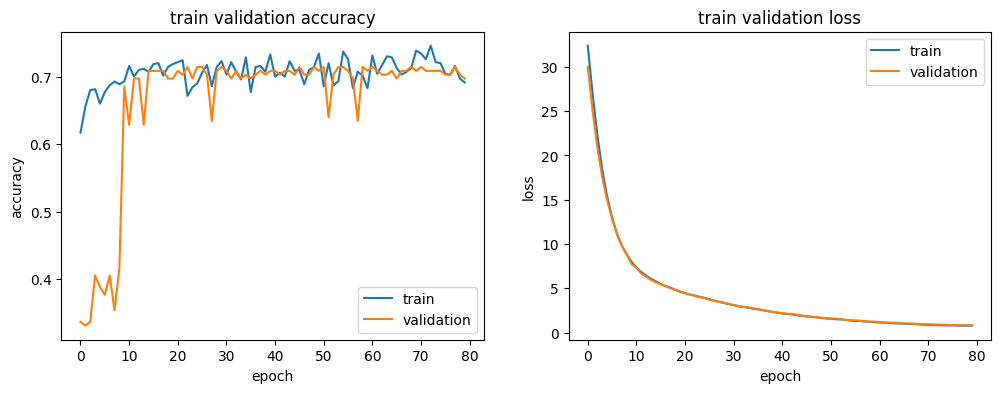

In [32]:
# Train and Validation accuracy and loss
f = plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.title('train validation accuracy')
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(1,2,2)
plt.title('train validation loss')
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

In [33]:
spec2_test = spec2_file['spec_test']
y2_test_spec = spec2_file['y_test']

In [34]:
# Feature Scaling
spec2_test_scaled = spec2_test / np.amax(spec2_test)

# Reshape the data
N,row,col = spec2_test_scaled.shape
spec2_test_reshaped = spec2_test_scaled.reshape((N,row,col,1))

In [35]:
y2_prob = model4.predict(spec2_test_reshaped)
y2_pred = np.argmax(y2_prob, axis = -1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [36]:
# Accuracy
acc2_2d = round(accuracy_score(y2_pred,y2_test_spec),2)

In [37]:
# Confusion Matrix
cm_spec = confusion_matrix(y2_test_spec,y2_pred)
cm_2d_spec = ConfusionMatrixDisplay(confusion_matrix = cm_spec, display_labels = ['Happy', 'Relaxed', 'Sad'])

              precision    recall  f1-score   support

       Happy       0.97      1.00      0.98        32
     Relaxed       1.00      0.30      0.47        33
         Sad       0.60      1.00      0.75        33

    accuracy                           0.77        98
   macro avg       0.86      0.77      0.73        98
weighted avg       0.86      0.77      0.73        98



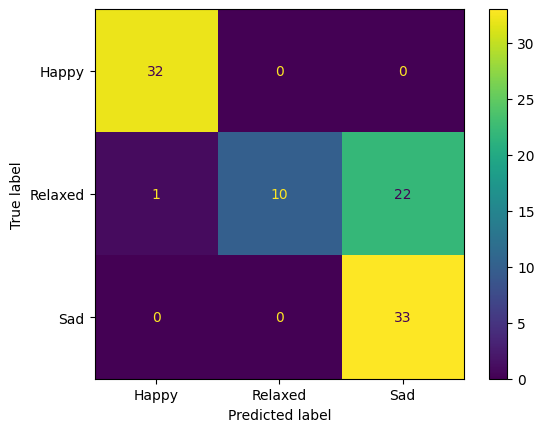

In [38]:
print(classification_report(y2_test_spec, y2_pred, target_names = ['Happy', 'Relaxed', 'Sad']))
cm_2d_spec.plot()
plt.show()

### 4.3 mel spectrogram

In [39]:
# Load mel data set
mel2_file = np.load("D:/UM/Project/Mozartify/project/Datasets/Features/Features2D/training models/mel2_train_test.npz")

mel2_train = mel2_file['mel_train']
y2_train = mel2_file['y_train']
mel2_train,mel2_val,y2_train,y2_val = train_test_split(mel2_train,y2_train, 
                                                       train_size = 0.8, 
                                                       random_state = 13, 
                                                       stratify= y2_train)

In [40]:
# Feature Scaling
mel2_train_scaled = (mel2_train - np.mean(mel2_train)) / np.std(mel2_train)
mel2_val_scaled = (mel2_val - np.amin(mel2_val)) / np.std(mel2_val)

In [41]:
# Reshape the data
N,row,col = mel2_train_scaled.shape
mel2_train_reshaped = mel2_train_scaled.reshape((N,row,col,1))

N,row,col = mel2_val_scaled.shape
mel2_val_reshaped = mel2_val_scaled.reshape((N,row,col,1))

In [42]:
f1,k1,a1 = 8,3,'relu'
mw1,mh1,sw1,sh1 = 2,3,2,2
f2,k2,a2 = 8,3,'relu'
mw2,mh2,sw2,sh2 = 2,3,2,2
f3,k3,a3 = 16,3,'relu'
mw3,mh3,sw3,sh3 = 2,3,2,2
d1,dr1,da1,r1 = 64,0.2,'relu',0.2
d2,dr2,da2,r2 = 32,0.2,'relu',0.2
num = 6
model6 = modelBuilder3L(mel2_train_reshaped,
                        f1,k1,a1,
                        mw1,mh1,sw1,sh1,
                        f2,k2,a2,
                        mw2,mh2,sw2,sh2,
                        f3,k3,a3,
                        mw3,mh3,sw3,sh3,
                        d1,dr1,da1,r1,
                        d2,dr2,da2,r2,
                        num)

Model: "CNN2D_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)               │ (None, 300, 400, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_1 (MaxPooling2D)   │ (None, 150, 200, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN1 (BatchNormalization)        │ (None, 150, 200, 8)    │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 150, 200, 8)    │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_2 (MaxPooling2D)   │ (None, 75, 100, 8)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN2 (BatchNormalization)        │ (None, 75, 100, 8)     │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 75, 100, 16)    │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2D_3 (MaxPooling2D)   │ (None, 38, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN3 (BatchNormalization)        │ (None, 38, 50, 16)     │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 30400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 64)             │     1,945,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout1 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout2 (Dropout)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Softmax (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,949,836 (7.44 MB)

 Trainable params: 1,949,772 (7.44 MB)

 Non-trainable params: 64 (256.00 B)

In [43]:
history6 = model6.fit(mel2_train_reshaped,y2_train,validation_data=(mel2_val_reshaped,y2_val),batch_size=20,epochs=80)

Epoch 1/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.5560 - loss: 33.7341 - val_accuracy: 0.3714 - val_loss: 29.2778
Epoch 2/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.6455 - loss: 27.3980 - val_accuracy: 0.3371 - val_loss: 23.7662
Epoch 3/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.6319 - loss: 22.0951 - val_accuracy: 0.3486 - val_loss: 19.4116
Epoch 4/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.6590 - loss: 18.0473 - val_accuracy: 0.3371 - val_loss: 16.2128
Epoch 5/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6398 - loss: 15.1791 - val_accuracy: 0.4057 - val_loss: 13.9823
Epoch 6/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6441 - loss: 12.9056 - val_accuracy: 0.3714 - val_loss: 12.5059
Epoch 7/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7030 - loss: 11.2182 - val_accuracy: 0.5771 - val_loss: 10.9490
Epoch 8/80
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6579 - loss: 9.9863 - val_accura

Text(0, 0.5, 'loss')

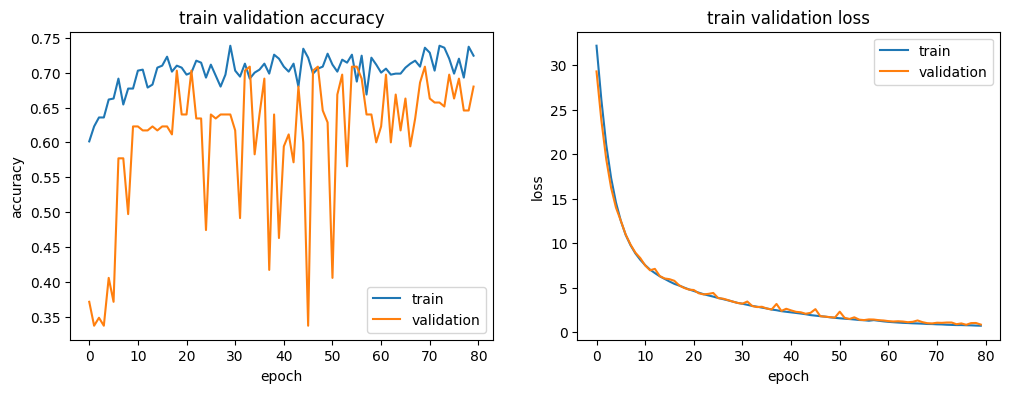

In [44]:
# Train and Validation accuracy and loss
f = plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
plt.title('train validation accuracy')
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(1,2,2)
plt.title('train validation loss')
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epoch')
plt.ylabel('loss')

In [45]:
mel2_test = mel2_file['mel_test']
y2_test_mel = mel2_file['y_test']

In [46]:
# Feature Scaling
mel2_test_scaled = (mel2_test - np.mean(mel2_test)) / np.std(mel2_test)

# Reshape the data
N,row,col = mel2_test_scaled.shape
mel2_test_reshaped = mel2_test_scaled.reshape((N,row,col,1))

In [47]:
y3_prob = model6.predict(mel2_test_reshaped)
y3_pred = np.argmax(y3_prob, axis = -1)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step WARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000017D76DF9440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [48]:
# Accuracy
acc3_2d = round(accuracy_score(y3_pred,y2_test_mel),2)

In [49]:
# Confusion Matrix
cm_mel = confusion_matrix(y2_test_mel,y3_pred)
cm_2d_mel = ConfusionMatrixDisplay(confusion_matrix = cm_mel, display_labels = ['Happy', 'Relaxed', 'Sad'])

              precision    recall  f1-score   support

       Happy       0.97      1.00      0.98        32
     Relaxed       1.00      0.30      0.47        33
         Sad       0.60      1.00      0.75        33

    accuracy                           0.77        98
   macro avg       0.86      0.77      0.73        98
weighted avg       0.86      0.77      0.73        98



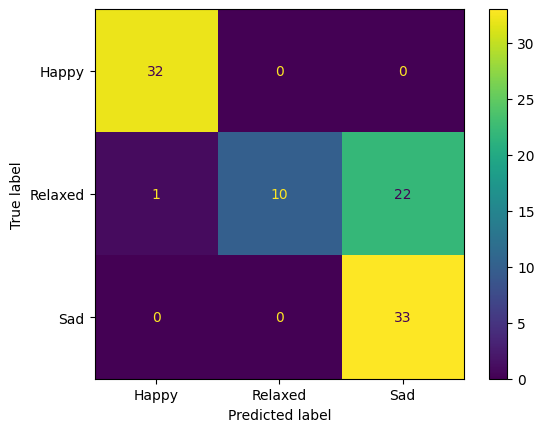

In [50]:
print(classification_report(y2_test_mel, y3_pred, target_names = ['Happy', 'Relaxed', 'Sad']))
cm_2d_mel.plot()
plt.show()

In [51]:
model2.save("D:/UM/Project/Mozartify/project/Model/CNN_models/2D_CNN/Conv2D_mfcc.h5")
model4.save("D:/UM/Project/Mozartify/project/Model/CNN_models/2D_CNN/Conv2D_spec.h5")
model6.save("D:/UM/Project/Mozartify/project/Model/CNN_models/2D_CNN/Conv2D_mel.h5")


## 5. Ensemble 3 models

In [52]:
spec_file_ense = np.load("D:/UM/Project/Mozartify/project/Datasets/Features/Features2D/training models/spec2_train_test.npz")
spec_ense_train = spec_file_ense['spec_train']
spec_ense_test = spec_file_ense['spec_test']
y_ense_train = spec_file_ense['y_train']
y_ense_test = spec_file_ense['y_test']
model_spec = load_model("D:/UM/Project/Mozartify/project/Model/CNN_models/2D_CNN/Conv2D_spec.h5")

In [53]:
mel_file_ense = np.load("D:/UM/Project/Mozartify/project/Datasets/Features/Features2D/training models/mel2_train_test.npz")
mel_ense_train = mel_file_ense['mel_train']
mel_ense_test =mel_file_ense['mel_test']
y_ense_train = mel_file_ense['y_train']
y_ense_test = mel_file_ense['y_test']
model_mel = load_model("D:/UM/Project/Mozartify/project/Model/CNN_models/2D_CNN/Conv2D_mel.h5")

In [54]:
mfcc_file_ense = np.load("D:/UM/Project/Mozartify/project/Datasets/Features/Features2D/training models/mfcc2_train_test.npz")
mfcc_ense_train = mfcc_file_ense['mfcc_train']
mfcc_ense_test =mfcc_file_ense['mfcc_test']
y1_ense_train = mfcc_file_ense['y_train']
y1_ense_test = mfcc_file_ense['y_test']
model_mfcc = load_model("D:/UM/Project/Mozartify/project/Model/CNN_models/2D_CNN/Conv2D_mfcc.h5")

In [59]:
# Feature Scaling
mfcc_ense_train_scaled = (mfcc_ense_train - np.mean(mfcc_ense_train))/np.std(mfcc_ense_train)
spec_ense_train_scaled = spec_ense_train / np.amax(spec_ense_train)
mel_ense_train_scaled = (mel_ense_train - np.mean(mel_ense_train))/np.std(mel_ense_train)

mfcc_ense_test_scaled = (mfcc_ense_test - np.mean(mfcc_ense_test))/np.std(mfcc_ense_test)
spec_ense_test_scaled = spec_ense_test / np.amax(spec_ense_test)
mel_ense_test_scaled = (mel_ense_test - np.mean(mel_ense_test))/np.std(mfcc_ense_test)

# Reshape the data
N,row,col = mfcc_ense_train_scaled.shape
mfcc_ense_train_reshaped = mfcc_ense_train_scaled.reshape((N,row,col,1))
N,row,col = spec_ense_train_scaled.shape
spec_ense_train_reshaped = spec_ense_train_scaled.reshape((N,row,col,1))
N,row,col = mel_ense_train_scaled.shape
mel_ense_train_reshaped = mel_ense_train_scaled.reshape((N,row,col,1))

N,row,col = mfcc_ense_test_scaled.shape
mfcc_ense_test_reshaped = mfcc_ense_test_scaled.reshape((N,row,col,1))
N,row,col = spec_ense_test_scaled.shape
spec_ense_test_reshaped = spec_ense_test_scaled.reshape((N,row,col,1))
N,row,col = mel_ense_test_scaled.shape
mel_ense_test_reshaped = mel_ense_test_scaled.reshape((N,row,col,1))


In [60]:
def get_majority(pred) :
    N = len(pred[0])
    vote = []
    for i in range(N) :
        elements = [j[i] for j in pred]
        elements = np.array(elements)
        uniq, freq = np.unique(elements, return_counts= True)
        vote.append(uniq[np.argmax(freq)])
    
    vote = np.array(vote)
    return vote

In [61]:
# Train 3 models
y_ense_prob1 = model_spec.predict(spec_ense_train_reshaped)
y_ense_pred1 = np.argmax(y_ense_prob1, axis= -1)

y_ense_prob2 = model_mfcc.predict(mfcc_ense_train_reshaped)
y_ense_pred2 = np.argmax(y_ense_prob2, axis= -1)

y_ense_prob3 = model_mel.predict(mel_ense_train_reshaped)
y_ense_pred3 = np.argmax(y_ense_prob3, axis= -1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


In [62]:
# 3 different predictions
train_pred = [y_ense_pred1, y_ense_pred2, y_ense_pred3]

In [63]:
y_train_pred = get_majority(train_pred)

In [64]:
# Model Evaluation
train_corr = len(y_train_pred) - np.count_nonzero(y_train_pred - y_ense_train)
train_acc = np.round((train_corr/ len(y_train_pred)),4)
train_acc

0.7371

In [65]:
# Test ensembled models
y_test_prob1 = model_spec.predict(spec_ense_test_reshaped)
y_test_pred1 = np.argmax(y_test_prob1, axis= -1)

y_test_prob2 = model_mfcc.predict(mfcc_ense_test_reshaped)
y_test_pred2 = np.argmax(y_test_prob2, axis= -1)

y_test_prob3 = model_mel.predict(mel_ense_test_reshaped)
y_test_pred3 = np.argmax(y_test_prob3, axis= -1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [66]:
test_pred = [y_test_pred1, y_test_pred2, y_test_pred3]

In [67]:
y_test_pred = get_majority(test_pred)

In [68]:
# Model Evaluation
test_corr = len(y_test_pred) - np.count_nonzero(y_test_pred - y_ense_test)
test_acc = np.round((test_corr/ len(y_test_pred)),4)
test_acc

0.7653

              precision    recall  f1-score   support

       Happy       0.97      1.00      0.98        32
     Relaxed       1.00      0.30      0.47        33
         Sad       0.60      1.00      0.75        33

    accuracy                           0.77        98
   macro avg       0.86      0.77      0.73        98
weighted avg       0.86      0.77      0.73        98



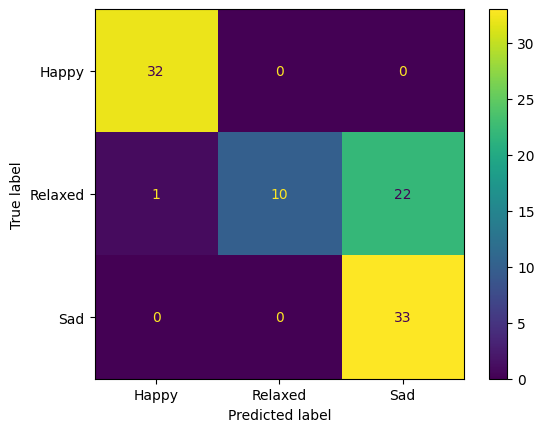

In [69]:
# Confusion Matrix
cm_ense = confusion_matrix(y_ense_test,y_test_pred)
cm_display_ense = ConfusionMatrixDisplay(confusion_matrix = cm_ense, display_labels = ['Happy', 'Relaxed', 'Sad'])
print(classification_report(y_ense_test, y_test_pred, target_names = ['Happy', 'Relaxed', 'Sad']))
cm_display_ense.plot()
plt.show()